In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

# 1.) Data Preprocessing

mnist dataset,  60000 images (28x28x1), 10 classes (single hand written digits)

Preprocessing steps:


*   Normalizing images (range[0:1])
*   Shufflin
*   Batching, Prefetching



In [ ]:
# In this homework we will work with the popular MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [ ]:
#Investigate data

#shape of train and test image and labels
print(train_images.shape)
print(np.max(train_images[0]))
print(np.min(train_images[0]))

(60000, 28, 28)
255
0


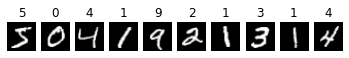

In [ ]:
fig, ax = plt.subplots(1,10)
for i in range(10):

    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

**Input Tensorflow Pipeline**

In [ ]:
#Normalization method range(0,1)
def normalize_0_1(x):
  #range 0 to 1
  max = tf.math.reduce_max(x)
  min = tf.math.reduce_min(x)
  result = tf.math.subtract(x, min)
  result = tf.math.divide(result,(max-min))
  return(result)

In [ ]:
# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_data = tf.data.Dataset.from_tensor_slices(train_images)
# expand the images to have explicitly the channel dimension 1
train_data = train_data.map(lambda img : tf.cast(tf.expand_dims(img, -1), tf.float32))
train_data = train_data.map(lambda img : normalize_0_1(img))

train_data = train_data.shuffle(buffer_size=128)
train_data = train_data.batch(64)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(test_images)
# expand the images to have explicitly the channel dimension 1
test_data = test_data.map(lambda img : tf.cast(tf.expand_dims(img, -1), tf.float32))
test_data = test_data.map(lambda img : normalize_0_1(img))

test_data = test_data.shuffle(buffer_size=128)
test_data = test_data.batch(64)
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
#check whether normalizing was successful
for i in train_data.take(1):
  print(i.shape)
  print(np.max(i))
  print(np.min(i))

(64, 28, 28, 1)
1.0
0.0


# 2.) Model

**2.1) Convolutional Autoencoder**
To downsample we use maxpooling-layers instead of modifying the strides of the convolutions.

In [ ]:
class Encoder(tf.keras.Model):

  def __init__(self, embedding_size = 10):
    super(Encoder, self).__init__()
    
    activation = tf.keras.activations.relu
    self.cov1 = tf.keras.layers.Conv2D(filters = 64,
                                       kernel_size = (3,3),
                                       strides = (1,1),
                                       padding = "same",
                                       activation = activation,
                                       input_shape = (28,28,1))
    self.maxpool1 = tf.keras.layers.MaxPool2D()
    self.cov2 = tf.keras.layers.Conv2D(filters = 64,
                                       kernel_size = (3,3),
                                       strides = (1,1),
                                       padding = "same",
                                       activation = activation)
    self.maxpool2 = tf.keras.layers.MaxPool2D()

    self.flatten = tf.keras.layers.Flatten()
    self.output_layer = tf.keras.layers.Dense(units = embedding_size,
                                        activation = activation)

  def call(self, x, training = True, debug = False):
    if debug:
      print("Input Encoder: " +str(x.shape))
    x = self.cov1(x)
    x = self.maxpool1(x)
    x = self.cov2(x)
    x = self.maxpool2(x)

    if debug:
      print("Shape before Flatten (after downsampling): " + str(x.shape))

    x = self.flatten(x)
    x = self.output_layer(x)

    if debug:
      print("Output Encoder :" + str(x.shape))
    return x

In [ ]:
class Decoder(tf.keras.Model):

  def __init__(self, embedding_size = 10):
    super(Decoder, self).__init__()

    activation = tf.keras.activations.relu
    self.input_layer = tf.keras.layers.Dense(units = np.product((7,7,64)),
                                       activation = activation,
                                       )

    self.trans_cov1 = tf.keras.layers.Conv2DTranspose(filters=64,
                                                      kernel_size = (3,3),
                                                      strides = (2,2),
                                                      padding = "same",
                                                      activation = activation)
    self.trans_cov2 = tf.keras.layers.Conv2DTranspose(filters=64,
                                                      kernel_size = (3,3),
                                                      strides = (2,2),
                                                      padding = "same",
                                                      activation = activation)
    self.output_layer = tf.keras.layers.Conv2D(filters = 1,
                                               kernel_size = (3,3),
                                               padding = "same",
                                               activation = tf.keras.activations.sigmoid)
  
  def call(self, x, batch_size, training = True, debug = False):
    x = self.input_layer(x)
    x = tf.reshape(x, (batch_size, 7, 7, 64))
    if debug:
      print("Shape after reshape (restore dimensionality): " + str(x.shape))

    x = self.trans_cov1(x)
    x = self.trans_cov2(x)
    if debug:
      print("Shape after upsampling: " + str(x.shape))

    x = self.output_layer(x)
    if debug:
      print("Output Decoder :" + str(x.shape))
    return x

In [ ]:
class Cov_Autoencoder(tf.keras.Model):

  def __init__(self, embedding_size = 10):
    super(Cov_Autoencoder, self).__init__()
    
    self.encoder = Encoder(embedding_size = embedding_size)
    self.decoder = Decoder(embedding_size = embedding_size)

  def call(self, x, training = True, debug = False):
    batch_size, _, _, _ = x.shape
    x = self.encoder(x, training = training, debug = debug)
    x = self.decoder(x, batch_size, training = training, debug = debug)
    
    return x

Lets check wether the dimensionality is correctly transformed using our autoencoder

In [ ]:
for i in train_data.take(1):
  autoenc = Cov_Autoencoder(embedding_size = 10)
  y = autoenc(i, debug = True)

Input Encoder: (64, 28, 28, 1)
Shape before Flatten (after downsampling): (64, 7, 7, 64)
Output Encoder :(64, 10)
Shape after reshape (restore dimensionality): (64, 7, 7, 64)
Shape after upsampling: (64, 28, 28, 64)
Output Decoder :(64, 28, 28, 1)


**2.2) Variational Autoencoder**

In [ ]:
#Keine Ahnung, ob wir genug Zeit dafür haben

# 3.) Training

**3.1) Convolutional Autoencoder**

In [ ]:
#General Hyperparameters
trainforNepochs=10                                    
learning_rate=0.001                                      
running_average_factor = 0.95                           
lossfunction= tf.keras.losses.MeanSquaredError()              #we use MSE
optimizer = tf.keras.optimizers.Adam(learning_rate)           #we use ADAM as optimizer

#tf.keras.backend.clear_session()
model = Cov_Autoencoder(embedding_size = 10)

In [ ]:
@tf.function
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input, training)
    loss = loss_function(target, prediction) 
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_loss_aggregator = []
  
  img_before = 0
  img_after = 0
  for input in test_data:
    index = np.random.randint(0,len(input))
    img_before = input[index]
    prediction = model(input, training) 
    img_after = prediction[index]
    sample_test_loss = loss_function(input, prediction) #loss is being generated between input and reconstructed picture
    test_loss_aggregator.append(sample_test_loss.numpy())

  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(tf.reshape(img_before,(28,28)), cmap = 'gray')
  axarr[0].set_title("Before")
  axarr[0].axis("off")
  axarr[1].imshow(tf.reshape(img_after,(28,28)), cmap = 'gray')
  axarr[1].set_title("After")
  axarr[1].axis("off")
  plt.show()
  test_loss = np.mean(test_loss_aggregator)

  return test_loss

Since the autoencoder is not yet trained,so the reconstructed image is random.

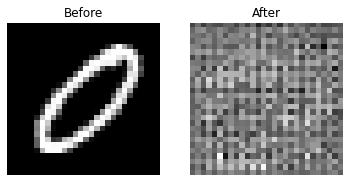

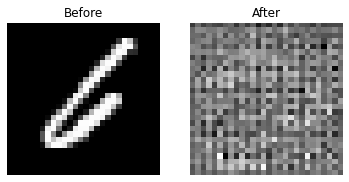

In [ ]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []

#testing once before we begin, so that be have the first datapoints
test_loss = test(model, test_data, lossfunction)
test_losses.append(test_loss)


#check how model performs on train data once before we begin, so that we have a baseline
train_loss = test(model, train_data, lossfunction)
train_losses.append(train_loss)

In [ ]:
#After training once the model is built and we can look at its architecture and its parameters
print(model.summary())

Model: "cov__autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  68938     
_________________________________________________________________
decoder_1 (Decoder)          multiple                  108929    
Total params: 177,867
Trainable params: 177,867
Non-trainable params: 0
_________________________________________________________________
None


**Training Loop**

Epoch: 1 of 10 Time remaining: Unknown seconds.       [----------------------------------------------------------------------------------------------------]

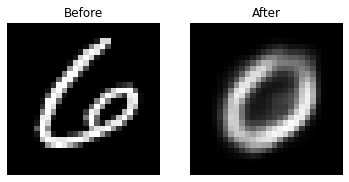

Epoch: 2 of 10 Time remaining: 68.0 seconds.       [==========------------------------------------------------------------------------------------------]

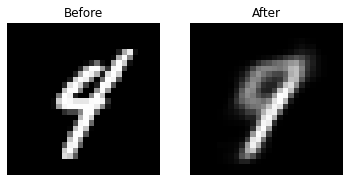

Epoch: 3 of 10 Time remaining: 56.0 seconds.       [====================--------------------------------------------------------------------------------]

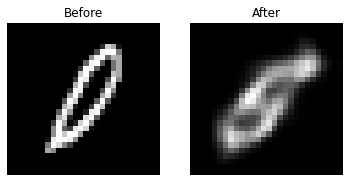

Epoch: 4 of 10 Time remaining: 48.0 seconds.       [==============================----------------------------------------------------------------------]

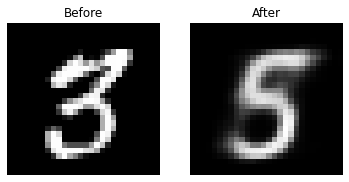

Epoch: 5 of 10 Time remaining: 41.0 seconds.       [========================================------------------------------------------------------------]

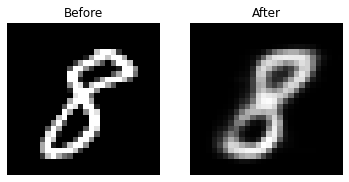

Epoch: 6 of 10 Time remaining: 34.0 seconds.       [==================================================--------------------------------------------------]

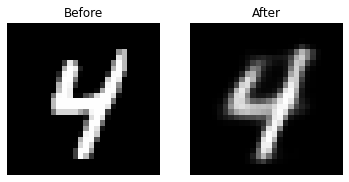

Epoch: 7 of 10 Time remaining: 27.0 seconds.       [============================================================----------------------------------------]

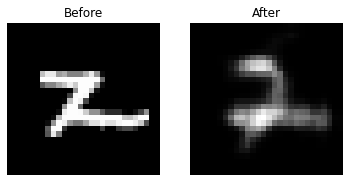

Epoch: 8 of 10 Time remaining: 20.0 seconds.       [======================================================================------------------------------]

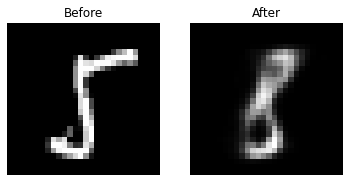

Epoch: 9 of 10 Time remaining: 13.0 seconds.       [================================================================================--------------------]

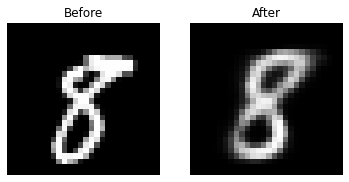

Epoch: 10 of 10 Time remaining: 7.0 seconds.       [==========================================================================================----------]

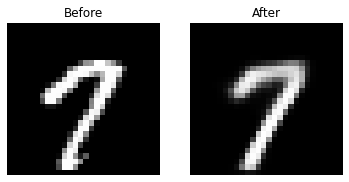

Finished after 67.0 seconds.


In [ ]:
# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #!!!!!!!!!!!!just some fun runtime approximation that you can ignore :D
    if epoch == 0:              #before the first epoch we dont know how much time is going to pass.
      start = time.time()       #what we know is, when we started!
      time_remaining="Unknown"
    else:
      now = time.time()                                         
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print("",end="\r")
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+" Time remaining:", time_remaining, "seconds.       "+"["+"="*int((epoch/trainforNepochs)*100)+"-"*int(((trainforNepochs-epoch)/trainforNepochs)*100)+"]", end="")
    #!!!!!!!!!!!end of the runtime approximation
    


    #training (and checking in with training)
    running_average = 0
    for input in train_data:                           #Training the model as long as we have training data
        train_loss = train_step(model, input, input, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss


    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss = test(model, test_data, lossfunction)
    test_losses.append(test_loss)
    


now = time.time()

print("Finished after",round(now-start,0),"seconds.")

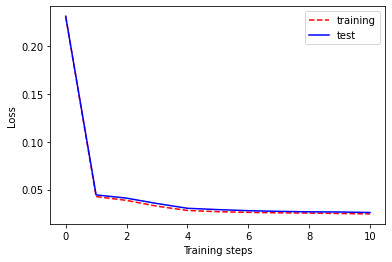

In [ ]:
# Visualize loss for training and test data. 
# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses,'r--')
line2, = plt.plot(test_losses, 'b-')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

**3.2 Variational Autoencoder**

same thing for VAE

# 4.) Latent Space Analysis

In [ ]:
#Prepare Test Data Set for Analysis
 

LSA_test_data_img = tf.data.Dataset.from_tensor_slices(test_images)
# expand the images to have explicitly the channel dimension 1
LSA_test_data_img = LSA_test_data_img.map(lambda img : tf.cast(tf.expand_dims(img, -1), tf.float32))
LSA_test_data_img = LSA_test_data_img.map(lambda img : normalize_0_1(img))

LSA_test_data_labels = tf.data.Dataset.from_tensor_slices(test_labels)

LSA_test_data = tf.data.Dataset.zip((LSA_test_data_img, LSA_test_data_labels))
LSA_test_data = LSA_test_data.batch(1000)

In [ ]:
from sklearn.manifold import TSNE

embeddings = []
embed_pre = []
embed = []
labels = []
for data in LSA_test_data.take(1):
  #plt.imshow(tf.reshape(data[0][0],(28,28)))
  embed_pre = model.encoder(data[0], training = False)
  labels = data[1]
  print(embed_pre.shape)
  #print(embed.shape)
  embed = TSNE(n_components = 2).fit_transform(embed_pre)
  print(embed.shape)
  print(data[1].shape)
  

print(embed.shape)
print(labels.shape)
  
for i in range(len(embed)):
    embeddings.append((embed[i], labels[i].numpy()))

(1000, 10)
(1000, 2)
(1000,)
(1000, 2)
(1000,)


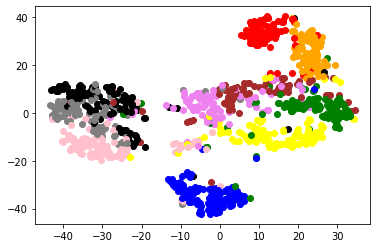

In [ ]:
colors = {0:'red',1:'blue',2:'yellow',3:'green',4:'black',5:'brown',6:'orange',7:'pink',8:'violet',9:'grey'}

for emb in embeddings:
  #print(emb[0])
  #print(emb[1])
  plt.scatter(emb[0][0], emb[0][1], marker = "o", color = colors[emb[1]])

The picture above describes the embedding representation, reduced to 2 dimensions, of elements of different classes (depicted by different colors). As you can see, they form semantic regions in the latent space. In a VAE one would expect the regions to fill out the complete space.

Before Interpolation


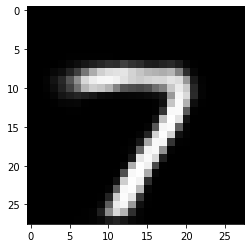

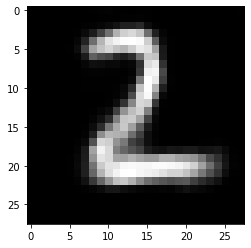

Interpolation Process


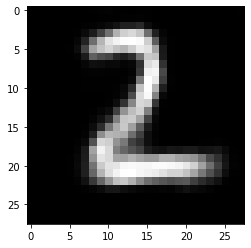

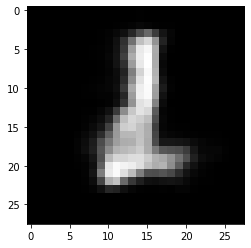

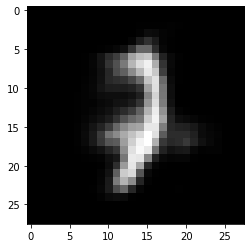

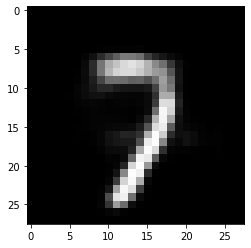

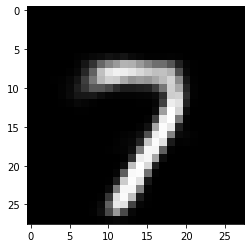

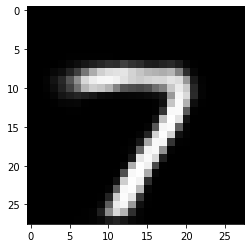

In [ ]:
def Embed_decode_show(embed):
  embed = tf.expand_dims(embed, 1)
  embed = tf.reshape(embed, (1,10))
  img = model.decoder(embed, batch_size = 1, training = False)
  plt.imshow(tf.reshape(img,(28,28)), cmap = 'gray')
  plt.show()


#interpolate between to embeddings and restruct a image based on that
emb1 = embed_pre[0]
emb2 = embed_pre[1]
print("Before Interpolation")
Embed_decode_show(emb1)
Embed_decode_show(emb2)
interpolation_emb = emb1 - emb2

print("Interpolation Process")
for i in range(0,11,2):
  f=i/10
  interpolation_emb=f*emb1+(1-f)*emb2
  Embed_decode_show(interpolation_emb)



In the pictures above one can see the pictures that were generated by interpolating the embeddings of two different classes. Especially interesting are the pictures with interpolation factor i=0,4 and i=0,6 since these are mixtures of both classes.